In [1]:
import argparse
import re
from pathlib import Path

import pandas as pd


def _get_avg_scc(logs, epoch_num):
    train_logs = re.findall(rf"Epoch\(train\).*\[{epoch_num}\]\[\s*\d+/\d+\].*top1_acc: (\d+\.\d+)", logs)
    # print("train_logs:", train_logs)
    train_top1_acc = [float(log) for log in train_logs]
    if len(train_top1_acc) == 0:
        return None, None
    train_avg_acc = sum(train_top1_acc) / len(train_top1_acc)

    val_logs = re.findall(rf"Epoch\(val\).*\[{epoch_num}\]\[\d+/\d+\].*acc/top1: (\d+\.\d+)", logs)
    # print("val_logs", val_logs)
    val_top1_acc = [float(log) for log in val_logs]
    if len(val_top1_acc) == 0:
        return None, None
    val_avg_acc = sum(val_top1_acc) / len(val_top1_acc)
    return train_avg_acc, val_avg_acc


def prune_log_filename(log_filename):
    start_str = "rgb-"
    end_str = "."

    start_index = log_filename.find(start_str) + len(start_str)
    end_index = log_filename.find(end_str)

    extracted_str = log_filename[start_index:end_index + 1]
    return extracted_str

def get_avg_acc(log_file_path, epoch_num):
    with open(log_file_path, "r") as f:
        logs = f.read()
    train_avg_acc, val_avg_acc = _get_avg_scc(logs, epoch_num)

    # TODO: train can be inaccurate due to the last batch size, need weights or discard the last batch in the future
    print(f"Average accuracy of epoch {epoch_num} (train): {train_avg_acc}")
    print(f"Top1 accuracy of epoch {epoch_num} (val): {val_avg_acc}")


def plot_avg_acc(log_file_path, epoch_num, out_dir: Path = Path("result_plots/")):
    with open(log_file_path, "r") as f:
        logs = f.read()

    # plot acc curve
    train_avg_accs = []
    val_avg_accs = []
    for epoch in range(1, epoch_num + 1):
        train_avg_acc, val_avg_acc = _get_avg_scc(logs, epoch)
        train_avg_accs.append(train_avg_acc)
        val_avg_accs.append(val_avg_acc)
    # plot and save the fig
    import matplotlib.pyplot as plt

    plt.plot(range(1, epoch_num + 1), train_avg_accs, label="train")
    plt.plot(range(1, epoch_num + 1), val_avg_accs, label="test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    # get basename
    import os

    # get parent's parent dir name as the log filename
    # make log file path a posix path
    log_file_path = Path(os.path.abspath(log_file_path)).as_posix()
    log_filename = str(Path(log_file_path).parent.parent.name)
    out_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_dir / str("acc-" + log_filename.replace(".log", ".png")))
    plt.close()

    # save the accs to a csv txt file
    df = pd.DataFrame({"epoch": range(1, epoch_num + 1), "train_avg_acc": train_avg_accs, "val_avg_acc": val_avg_accs})
    
    extracted_str = prune_log_filename(log_filename)
    df.to_csv(out_dir / str("acc-" + extracted_str + ".csv"), index=False)
    return df

In [2]:
log_file_path_infos = [
    # r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v10-st-combined-random-crop-sampling-sequential/20231103_161842/20231103_161842.log",
    # (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-drop-div-combined/20231020_174806/20231020_174806.log", "timesformer-v13-dd-combined"),
    # (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-drop-div-video/20231020_180639/20231020_180639.log", "timesformer-v13-dd-video"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-all-random-crop/20231023_141950/20231023_141950.log", "timesformer-inclusive-all"),
    # (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-all-random-crop-sequential/20231031_032100/20231031_032100.log", "timesformer-inclusive-all-sequential"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-all-random-crop-sequential/combined.log", "timesformer-inclusive-all-sequential"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-corrected-combined_with_negative-random-crop-sampling-sequential/20231031_064750/20231031_064750.log", "timesformer-inclusive-combined-N"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-corrected-combined-random-crop-sampling-sequential/20231028_042501/20231028_042501.log", "timesformer-inclusive-combined"),
    (r"./work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-inclusive-corrected-v1-all-clipLen=3-trainClipNum=3-valClipNum=3/20231029_141110/20231029_141110.log", "tsn-inclusive-all-random"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-drop-div-video-clipLen=3-trainClipNum=3-valClipNum=3/20231019_003517/20231019_003517.log", "tsn-dd-video"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-drop-div-combined-clipLen=2-trainClipNum=3-valClipNum=3/20231019_003517/20231019_003517.log", "tsn-dd-combined"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v12-st-video-clipLen=2-trainClipNum=3-valClipNum=3/20231001_154756/20231001_154756.log", "tsn-st-video"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v12-st-combined-clipLen=3-trainClipNum=3-valClipNum=3/20231005_043230/20231005_043230.log", "tsn-st-combined"),
    # (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-with-mitosis-type-combined-random-crop/20231025_122045/20231025_122045.log", "timesformer-v13-inclusive-with-mitosis-type-combined"),


    ]

v10_log_file_path_infos = [
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v10-st-video-clipLen=3-trainClipNum=3-valClipNum=3/20230721_045839/20230721_045839.log", "tsn-st-video-clipLen=3"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v10-st-video-clipLen=2-trainClipNum=3-valClipNum=3/20230811_124027/20230811_124027.log", "tsn-st-video-clipLen=2"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v10-st-video-clipLen=1-trainClipNum=3-valClipNum=3/20230811_124019/20230811_124019.log", "tsn-t-video-clipLen=1"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v10-st-combined-clipLen=3-trainClipNum=3-valClipNum=3/20230718_022049/20230718_022049.log", "tsn-st-combined-clipLen=3"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v10-st-combined-clipLen=2-trainClipNum=3-valClipNum=3/20230717_030248/20230717_030248.log", "tsn-st-combined-clipLen=2"),
    (r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v10-st-combined-clipLen=1-trainClipNum=3-valClipNum=3/20230811_130716/20230811_130716.log", "tsn-st-combined-clipLen=1"),
(r"/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v10-st-combined-random-crop-sampling-sequential/20231103_161842/20231103_161842.log", "timesformer-st-combined"),    


    
]
# log_file_path_infos = v10_log_file_path_infos
# epoch_num = 150
EPOCH_NUM = 70

log_file_paths = [log_file_path_info[0] for log_file_path_info in log_file_path_infos]
log_file_titles = [log_file_path_info[1] for log_file_path_info in log_file_path_infos]
interval = 1


In [3]:
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Training", "Testing"))

# Get a color palette with as many colors as there are log files
colors = px.colors.qualitative.Plotly[:len(log_file_paths)]

# Iterate over the log files
for i, log_file_path in enumerate(log_file_paths):
    # Read the log file and calculate the training and validation accuracies
    with open(log_file_path, "r") as f:
        logs = f.read()
    train_avg_accs = []
    val_avg_accs = []
    for epoch in range(1, EPOCH_NUM + 1, interval):
        train_avg_acc, val_avg_acc = _get_avg_scc(logs, epoch)
        if train_avg_acc is None:
            break
        train_avg_accs.append(train_avg_acc)
        val_avg_accs.append(val_avg_acc)

    # Create a trace for the training data
    trace_train = go.Scatter(
        x=list(range(1, len(train_avg_accs) + 1)),
        y=train_avg_accs,
        mode='lines',
        name=f'{log_file_titles[i]}',  # use the log file title as the trace name
        line=dict(color=colors[i]),  # set the line color based on the log file index
        legendgroup="group1",  # assign this trace to legend group 1
    )

    # Create a trace for the validation data
    trace_val = go.Scatter(
        x=list(range(1, EPOCH_NUM + 1)),
        y=val_avg_accs,
        mode='lines',
        name=f'test-{log_file_titles[i]}',  # use the log file title as the trace name
        line=dict(color=colors[i]),  # set the line color based on the log file index
        legendgroup="group2",  # assign this trace to legend group 2
        showlegend=False,  # hide this trace in the legend
    )

    # Add the traces to the subplot
    fig.add_trace(trace_train, row=1, col=1)
    fig.add_trace(trace_val, row=1, col=2)

# Update the layout of the figure
fig.update_layout(
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    autosize=False,
    width=800 * 2,
    height=600,
    margin=go.layout.Margin(
        l=50,  # left margin
        r=50,  # right margin
        b=100,  # bottom margin
        t=100,  # top margin
        pad=10
    ),
    legend_tracegroupgap=120,  # increase the gap between the legend groups
)

# Add x-axis and y-axis labels to the testing curve plot
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)

# Add subplot titles
fig.update_layout(
    title_text="Full LivecellAction dataset",
    # title_text = "A 13-sample small dataset",
    title_font=dict(size=30),
    title_x=0.44,
    title_y = 0.97
)

# Fix the y-axis range for all subplots
fig.update_yaxes(range=[0.8, 1])

fig.update_xaxes(title_text="Epoch", title_standoff=25, title_font=dict(size=18))
fig.update_yaxes(title_text="Accuracy", title_standoff=25, title_font=dict(size=18))


# Move the subplot titles up
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].update(y=1.05, font=dict(size=20))  # adjust the y attribute as needed

# Show the figure
fig.show()

In [4]:

import matplotlib.pyplot as plt

log_file_path = log_file_paths[0]


with open(log_file_path, "r") as f:
    logs = f.read()

# plot acc curve
train_avg_accs = []
val_avg_accs = []
for epoch in range(1, EPOCH_NUM + 1, interval):
    train_avg_acc, val_avg_acc = _get_avg_scc(logs, epoch)
    if train_avg_acc is None:
        break
    train_avg_accs.append(train_avg_acc)
    val_avg_accs.append(val_avg_acc)
# plot and save the fig

########################matplotlib########################
# import matplotlib.pyplot as plt

# plt.plot(range(1, len(train_avg_accs) + 1), train_avg_accs, label="train")
# plt.plot(range(1, len(val_avg_accs) + 1), val_avg_accs, label="test")
# plt.xlabel("epoch")
# plt.ylabel("accuracy")
# plt.legend()
# get basename
import os

# get parent's parent dir name as the log filename
# make log file path a posix path
log_file_path = Path(os.path.abspath(log_file_path)).as_posix()
log_filename = str(Path(log_file_path).parent.parent.name)
# out_dir.mkdir(parents=True, exist_ok=True)
# plt.savefig(out_dir / str("acc-" + log_filename.replace(".log", ".png")))
plt.show()
plt.close()

# save the accs to a csv txt file
df = pd.DataFrame({"epoch": range(1, len(train_avg_accs) + 1), "train_avg_acc": train_avg_accs, "val_avg_acc": val_avg_accs})

extracted_str = prune_log_filename(log_filename)
# df.to_csv(out_dir / str("acc-" + extracted_str + ".csv"), index=False)


import plotly.graph_objects as go
# Create a trace for the training data
trace_train = go.Scatter(
    x=list(range(1, len(train_avg_accs) + 1)),
    y=train_avg_accs,
    mode='lines',
    name='train'
)

# Create a trace for the validation data
trace_val = go.Scatter(
    x=list(range(1, EPOCH_NUM + 1)),
    y=val_avg_accs,
    mode='lines',
    name='test'
)

# Create a layout with the title and axis labels
layout = go.Layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    autosize=False,
    width=800,
    height=600,
    margin=go.layout.Margin(
        l=50,  # left margin
        r=50,  # right margin
        b=100,  # bottom margin
        t=100,  # top margin
        pad=10
    ),
    paper_bgcolor="LightSteelBlue",
)

# Create a Figure object
fig = go.Figure(data=[trace_train, trace_val], layout=layout)

# Show the figure
fig.show()


In [5]:
import plotly.subplots as sp

# Determine the number of rows for the subplots
num_rows = len(log_file_paths) // 4
if len(log_file_paths) % 4 != 0:
    num_rows += 1

# Create a subplot with 4 columns and a number of rows based on the number of log files
fig = sp.make_subplots(rows=num_rows, cols=4, subplot_titles=[log_file_titles[i] for i, path in enumerate(log_file_paths)])

# Iterate over the log files
for i, log_file_path in enumerate(log_file_paths):
    # Calculate the row and column for the current subplot
    row = i // 4 + 1
    col = i % 4 + 1

    # Read the log file and calculate the training and validation accuracies
    with open(log_file_path, "r") as f:
        logs = f.read()
    train_avg_accs = []
    val_avg_accs = []
    for epoch in range(1, EPOCH_NUM + 1, interval):
        train_avg_acc, val_avg_acc = _get_avg_scc(logs, epoch)
        if train_avg_acc is None:
            break
        train_avg_accs.append(train_avg_acc)
        val_avg_accs.append(val_avg_acc)

    # Create a trace for the training data
    trace_train = go.Scatter(
        x=list(range(1, len(train_avg_accs) + 1)),
        y=train_avg_accs,
        mode='lines',
        name='train',
        line=dict(color='blue'),  # set the line color to blue
        showlegend=False  # do not show this trace in the legend
    )

    # Create a trace for the validation data
    trace_val = go.Scatter(
        x=list(range(1, EPOCH_NUM + 1)),
        y=val_avg_accs,
        mode='lines',
        name='test',
        line=dict(color='red'),  # set the line color to red
        showlegend=False  # do not show this trace in the legend
    )

    # Add the traces to the subplot
    fig.add_trace(trace_train, row=row, col=col)
    fig.add_trace(trace_val, row=row, col=col)

# Update the layout of the figure
fig.update_layout(
    # title='Training and Validation Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    autosize=False,
    width=800 * 3,
    height=600 * num_rows,
    margin=go.layout.Margin(
        l=50,  # left margin
        r=50,  # right margin
        b=100,  # bottom margin
        t=100,  # top margin
        pad=10
    ),
    # paper_bgcolor="LightSteelBlue",
)
# Fix the y-axis range for all subplots
fig.update_yaxes(range=[0.8, 1])
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].update(y=1.05)  # adjust the y attribute as needed
# Show the figure
fig.show()

In [15]:
log_file_paths = ['/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-all-random-crop/20231023_141950/20231023_141950.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-all-random-crop-sequential/combined.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-corrected-combined_with_negative-random-crop-sampling-sequential/20231031_064750/20231031_064750.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-inclusive-corrected-combined-random-crop-sampling-sequential/20231028_042501/20231028_042501.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/timesformer-default-divst-v13-drop-div-combined/20231020_174806/20231020_174806.log',
#  './work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-inclusive-corrected-v1-all-clipLen=3-trainClipNum=3-valClipNum=3/20231029_141110/20231029_141110.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-drop-div-video-clipLen=3-trainClipNum=3-valClipNum=3/20231019_003517/20231019_003517.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-drop-div-combined-clipLen=2-trainClipNum=3-valClipNum=3/20231019_003517/20231019_003517.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v12-st-video-clipLen=2-trainClipNum=3-valClipNum=3/20231001_154756/20231001_154756.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v12-st-combined-clipLen=3-trainClipNum=3-valClipNum=3/20231005_043230/20231005_043230.log',
 '/home/ken67/livecellx/notebooks/scripts/mmdetection_classify/work_dirs/tsn_imagenet-pretrained-r50_8xb32-1x1x3-100e_kinetics400-rgb-v13-inclusive-corrected-v1-all-clipLen=3-trainClipNum=3-valClipNum=3/20231029_141110/20231029_141110.log']

log_file_titles = ['timesformer-inclusive-all',
 'timesformer-inclusive-all-sequential',
 'timesformer-inclusive-combined-N',
 'timesformer-inclusive-combined',
 "timesformer-dd-combined",

#  'tsn-inclusive-all-random',
 'tsn-dd-video',
 'tsn-dd-combined',
 'tsn-st-video',
 'tsn-st-combined',
 'tsn-inclusive-all']

In [13]:
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']  # List of markers

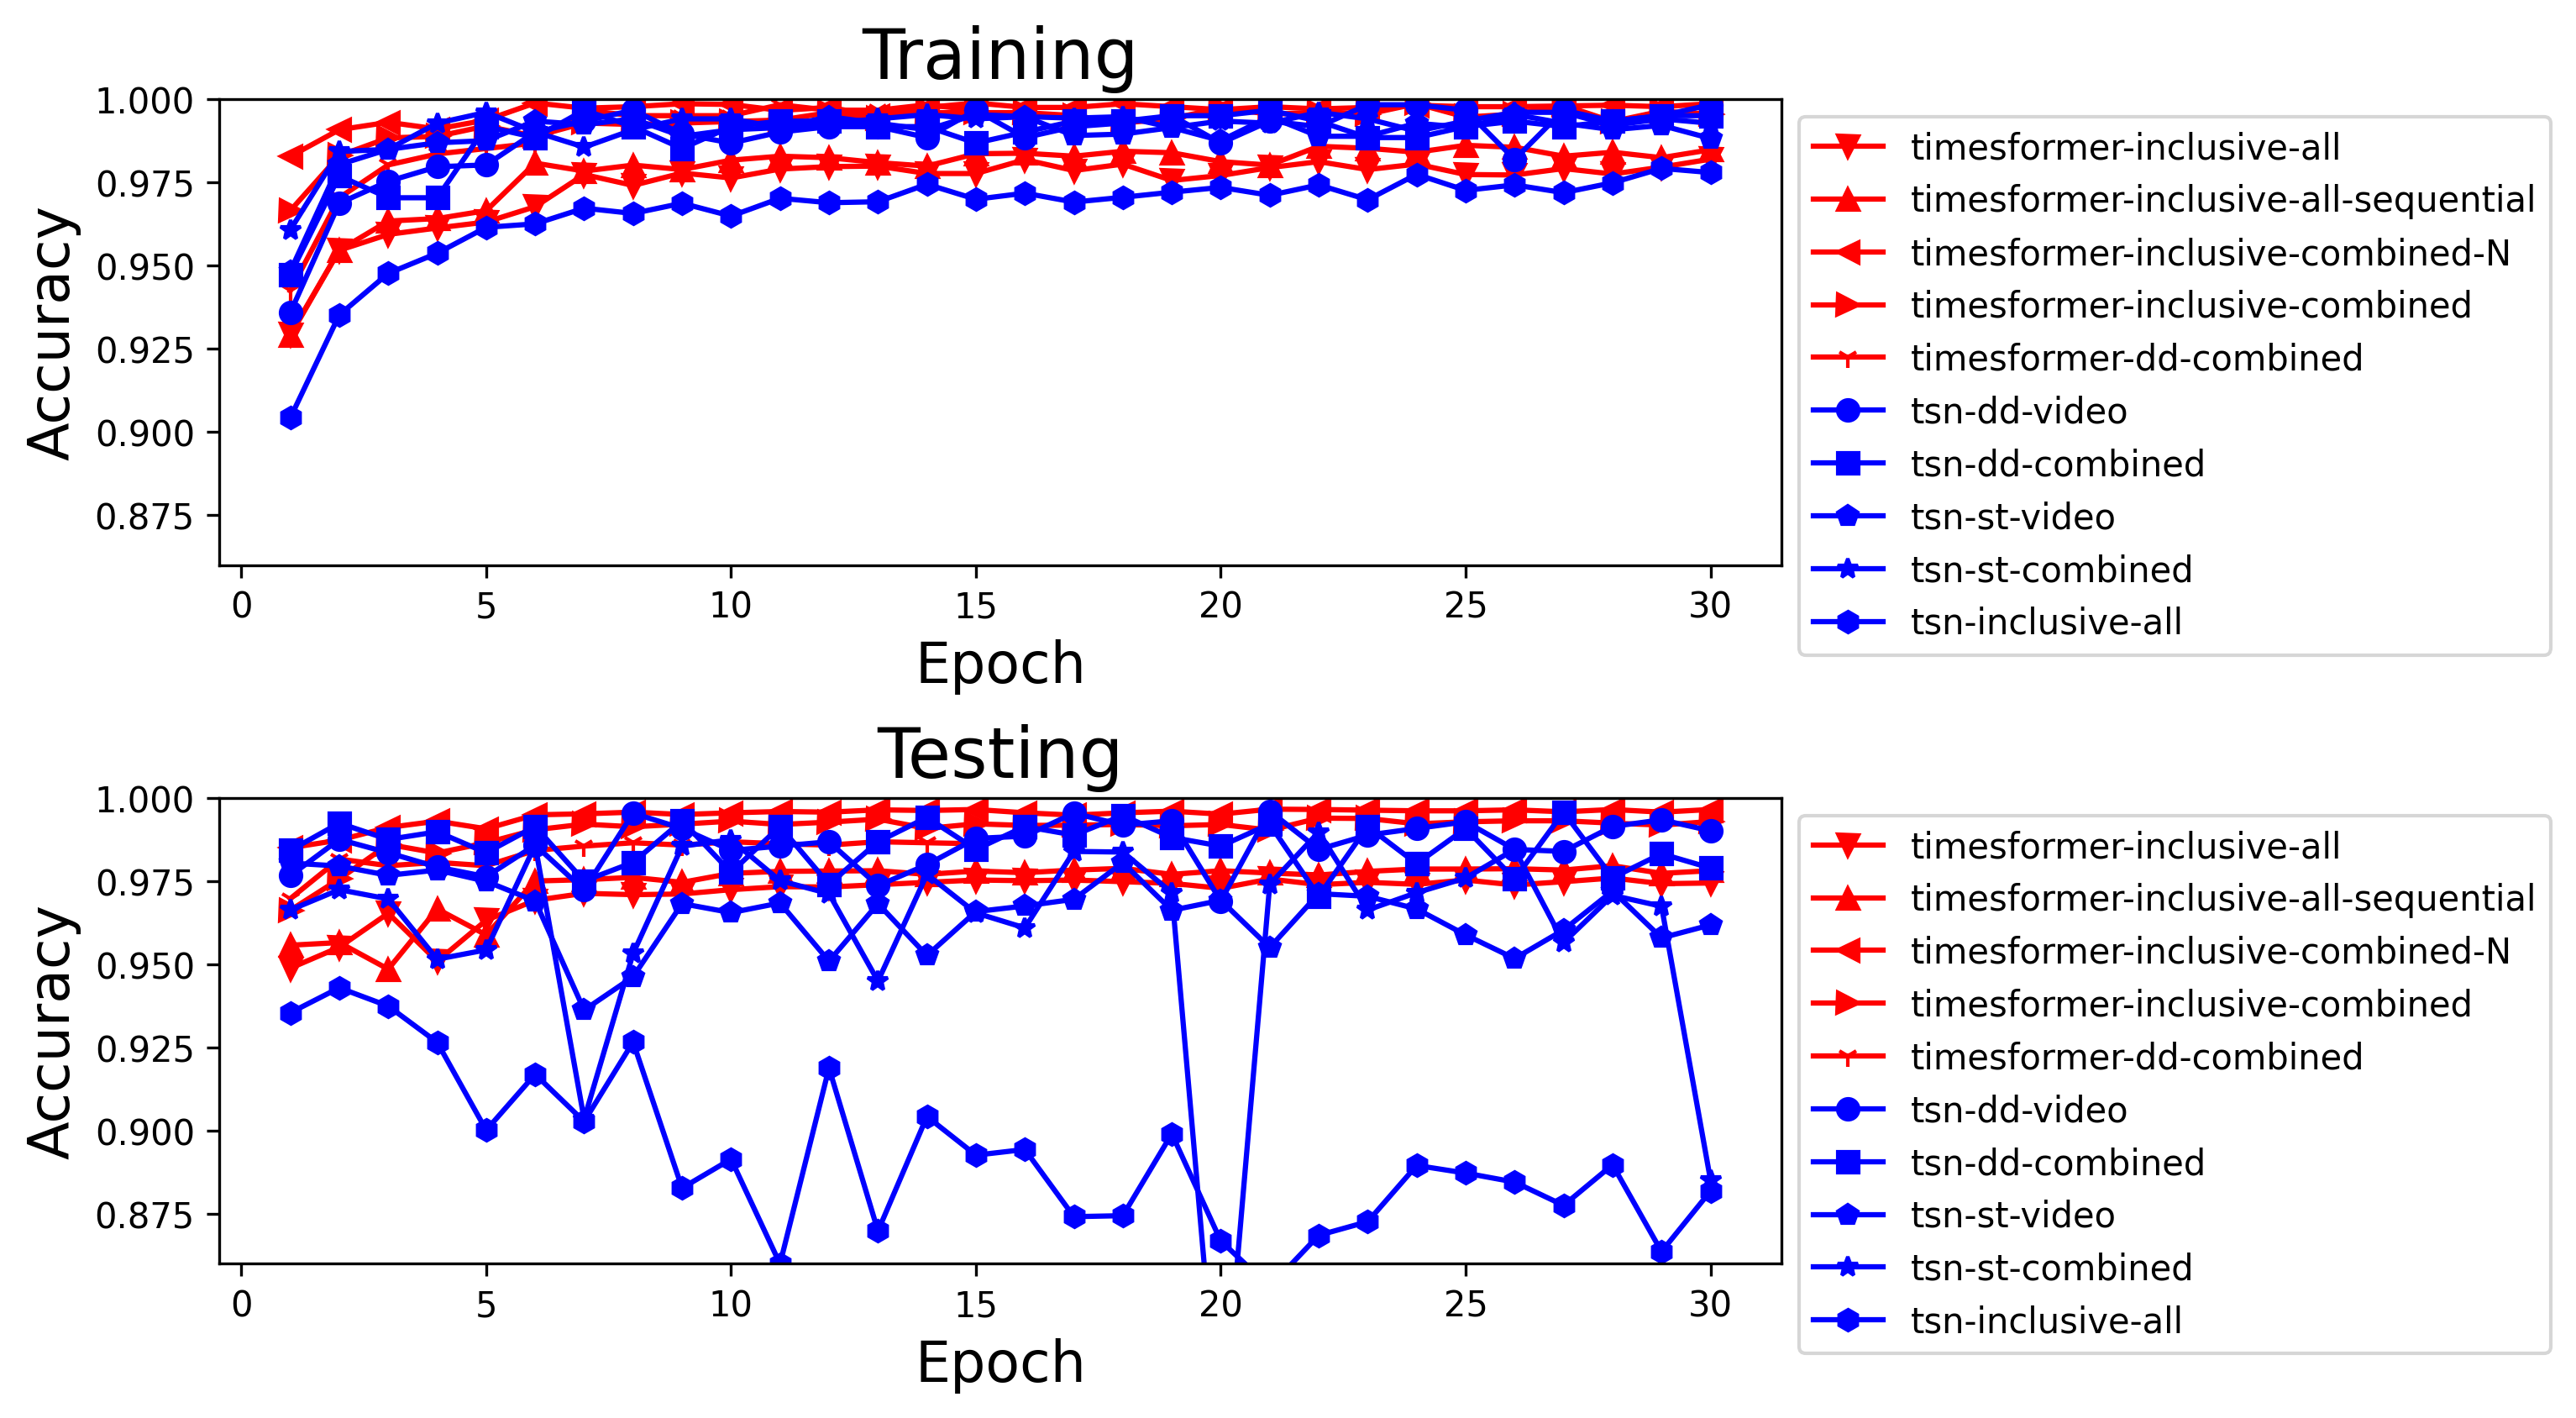

In [19]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=300)

# set hspace
fig.subplots_adjust(hspace=0.5)

EPOCH_NUM = 30
STEP = 1
# markers = ['^', 'o']  # List of markers
markers = ['v', '^', '<', '>', '1', 'o', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']  # List of markers
colors = ['red', 'blue']  # List of colors

# Iterate over the log files
for i, log_file_path in enumerate(log_file_paths):
    # Read the log file and calculate the training and validation accuracies
    with open(log_file_path, "r") as f:
        logs = f.read()
    train_avg_accs = []
    val_avg_accs = []
    for epoch in range(1, EPOCH_NUM + 1, interval):
        train_avg_acc, val_avg_acc = _get_avg_scc(logs, epoch)
        if train_avg_acc is None:
            break
        train_avg_accs.append(train_avg_acc)
        val_avg_accs.append(val_avg_acc)
    if log_file_path.find("timesformer") != -1:
        _marker = markers[0]
        _color = colors[0]
    else:
        _marker = markers[1]
        _color = colors[1]
    _marker = markers[i % len(markers)]
    # Plot the training data
    axs[0].plot(range(1, len(train_avg_accs) + 1, STEP), train_avg_accs[::STEP], marker=_marker, color=_color, label=log_file_titles[i])

    # Plot the validation data
    axs[1].plot(range(1, len(val_avg_accs) + 1, STEP), val_avg_accs[::STEP], marker=_marker, color=_color, label=log_file_titles[i])

# Set the titles of the subplots
axs[0].set_title('Training', fontsize=20)
axs[1].set_title('Testing', fontsize=20)

# Set the x-axis and y-axis labels of the subplots
for ax in axs:
    ax.set_xlabel('Epoch', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)

# Set the y-axis range for all subplots
for ax in axs:
    ax.set_ylim([0.86, 1])

# Add legends to the subplots
for ax in axs:
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))

# Show the figure
plt.show()